In [ ]:
!pip install libauc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 5.0 MB/s eta 0:00:00


In [ ]:
from medmnist import ChestMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader
from medmnist import ChestMNIST
from medmnist import INFO
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from libauc.losses import APLoss
from libauc.optimizers import SOAP
from libauc.models import resnet18 as ResNet18
from libauc.utils import ImbalancedDataGenerator
from libauc.metrics import auc_prc_score
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from libauc.sampler import DualSampler


In [ ]:
SEED = 2023
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

target_class=2 #klasyfikacja zapalenia płuc

In [ ]:
transform = Compose([ToTensor(), Normalize(mean=[.5], std=[.5])])


train_dataset_raw = ChestMNIST(split='train', transform=transform, download=True)
val_dataset_raw = ChestMNIST(split='val', transform=transform, download=True)
test_dataset_raw = ChestMNIST(split='test', transform=transform, download=True)

Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz


In [ ]:
#przekształcanie etykiet na binarne
def binarize_labels(dataset, target_class):
    dataset.labels = (dataset.labels.argmax(axis=1) == target_class).astype(float)
    return dataset

train_dataset_raw = binarize_labels(train_dataset_raw, target_class)
val_dataset_raw = binarize_labels(val_dataset_raw, target_class)
test_dataset_raw = binarize_labels(test_dataset_raw, target_class)

train_data, train_targets = train_dataset_raw.imgs, train_dataset_raw.labels
val_data, val_targets = val_dataset_raw.imgs, val_dataset_raw.labels
test_data, test_targets = test_dataset_raw.imgs, test_dataset_raw.labels

# Dodanie wymiaru kanału (dla grayscale)
train_images= train_data[:, :, :, None]
val_images = val_data[:, :, :, None]
test_images = test_data[:, :, :, None]

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, image_size=28, crop_size=24, mode='train'):
        self.images = images.astype(np.uint8)
        self.targets = targets
        self.mode = mode
        self.transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomCrop((crop_size, crop_size), padding=None),
            transforms.RandomHorizontalFlip(),
            transforms.Resize((image_size, image_size)),
        ])
        self.transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((image_size, image_size)),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        image = Image.fromarray(image.squeeze())
        if self.mode == 'train':
            image = self.transform_train(image)
        else:
            image = self.transform_test(image)
        return image, target, idx

In [ ]:
trainSet = ImageDataset(train_images, train_targets)
valSet = ImageDataset(val_images, val_targets, mode='test')
testSet = ImageDataset(test_images, test_targets, mode='test')

batch_size=32

sampling_rate = 0.5

#W każdym batchu potrzebujemy przynajmniej jednego reprezentanta obu klas
sampler = DualSampler(trainSet, batch_size=batch_size, sampling_rate=sampling_rate)


trainloader = DataLoader(trainSet, batch_size=batch_size, sampler=sampler, num_workers=2)
valloader = DataLoader(valSet, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testSet, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
#model ResNet18
model = ResNet18(pretrained=False, last_activation=None, num_classes=1)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model = model.cuda()

#funkcja kosztu i optymalizator SOAP z biblioteki libauc
loss_fn = APLoss(data_len=len(trainSet), margin=0.6, gamma=0.1)
optimizer = SOAP(model.parameters(), lr=1e-3, mode='adam', weight_decay=2e-4)

Start Training
------------------------------
epoch: 0, val_ap: 0.2148, best_val_ap: 0.2148, lr: 0.0010
epoch: 1, val_ap: 0.2311, best_val_ap: 0.2311, lr: 0.0010
epoch: 2, val_ap: 0.2160, best_val_ap: 0.2311, lr: 0.0010
epoch: 3, val_ap: 0.2447, best_val_ap: 0.2447, lr: 0.0010
epoch: 4, val_ap: 0.2283, best_val_ap: 0.2447, lr: 0.0010
epoch: 5, val_ap: 0.2567, best_val_ap: 0.2567, lr: 0.0010
epoch: 6, val_ap: 0.2320, best_val_ap: 0.2567, lr: 0.0010
epoch: 7, val_ap: 0.2586, best_val_ap: 0.2586, lr: 0.0010
epoch: 8, val_ap: 0.2431, best_val_ap: 0.2586, lr: 0.0010
epoch: 9, val_ap: 0.2716, best_val_ap: 0.2716, lr: 0.0010


<ipython-input-12-ed3c99243745>:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_chestmnist.pth'))


Test AP: 0.2420


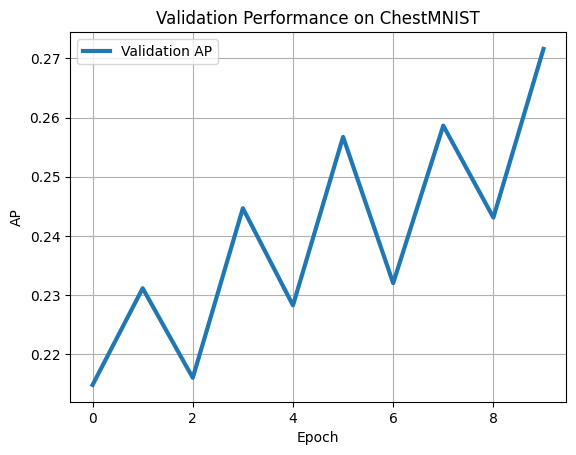

In [ ]:
total_epoch = 10

train_log, val_log, test_log = [], [], []
best_val = 0


print("Start Training")
print("-" * 30)
for epoch in range(total_epoch):

    model.train()
    for idx, (data, targets, index) in enumerate(trainloader):
        data, targets, index = data.cuda(), targets.cuda(), index.cuda()
        y_pred = model(data)
        y_prob = torch.sigmoid(y_pred)
        loss = loss_fn(y_prob, targets, index)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Walidacja
    model.eval()
    val_pred_list, val_true_list = [], []
    with torch.no_grad():
        for data in valloader:
            val_data, val_targets, _ = data
            val_data = val_data.cuda()
            y_pred = model(val_data)
            y_prob = torch.sigmoid(y_pred)
            val_pred_list.append(y_prob.cpu().detach().numpy())
            val_true_list.append(val_targets.numpy())
    val_true = np.concatenate(val_true_list)
    val_pred = np.concatenate(val_pred_list)

    val_ap = auc_prc_score(val_true, val_pred)
    val_log.append(val_ap)
    if best_val < val_ap:
        best_val = val_ap
        torch.save(model.state_dict(), 'best_model_chestmnist.pth')

    print(f"epoch: {epoch}, val_ap: {val_ap:.4f}, best_val_ap: {best_val:.4f}, lr: {optimizer.lr:.4f}")

# Testowanie
model.load_state_dict(torch.load('best_model_chestmnist.pth'))
model.eval()
test_pred_list, test_true_list = [], []
with torch.no_grad():
    for data in testloader:
        test_data, test_targets, _ = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        y_prob = torch.sigmoid(y_pred)
        test_pred_list.append(y_prob.cpu().detach().numpy())
        test_true_list.append(test_targets.numpy())
test_true = np.concatenate(test_true_list)
test_pred = np.concatenate(test_pred_list)

test_ap = auc_prc_score(test_true, test_pred)
print(f"Test AP: {test_ap:.4f}")

# Wizualizacja wyników
x = np.arange(len(val_log))
plt.plot(x, val_log, label='Validation AP', linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('AP')
plt.title('Validation Performance on ChestMNIST')
plt.legend()
plt.grid()
plt.show()


=== Metryki Testowe ===
AUC-PRC: 0.2420
AUC-ROC: 0.7823
Accuracy: 0.8248
Precision: 0.2387
Recall: 0.5235
F1-score: 0.3279

Confusion Matrix:
[[17543  3058]
 [  873   959]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.95      0.85      0.90     20601
     Class 1       0.24      0.52      0.33      1832

    accuracy                           0.82     22433
   macro avg       0.60      0.69      0.61     22433
weighted avg       0.89      0.82      0.85     22433



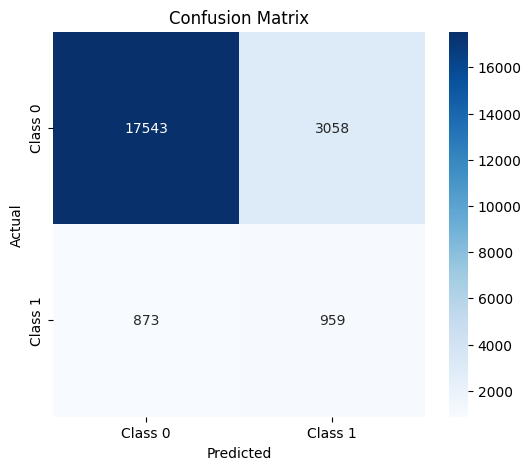

In [ ]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

# Obliczanie dodatkowych metryk
test_pred_binary = (test_pred > 0.5).astype(int)  # Binarne prognozy (próg 0.5)

# AUC-ROC
test_roc_auc = roc_auc_score(test_true, test_pred)

# Accuracy, Precision, Recall, F1-score
test_accuracy = accuracy_score(test_true, test_pred_binary)
test_precision = precision_score(test_true, test_pred_binary)
test_recall = recall_score(test_true, test_pred_binary)
test_f1 = f1_score(test_true, test_pred_binary)

# Confusion Matrix
test_cm = confusion_matrix(test_true, test_pred_binary)

# Classification Report
test_report = classification_report(test_true, test_pred_binary, target_names=["Class 0", "Class 1"])

# Wyświetlanie wyników
print("=== Metryki Testowe ===")
print(f"AUC-PRC: {test_ap:.4f}")
print(f"AUC-ROC: {test_roc_auc:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_f1:.4f}")
print("\nConfusion Matrix:")
print(test_cm)
print("\nClassification Report:")
print(test_report)

# Wizualizacja Confusion Matrix
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
